# Britney Spears Recommender Model

### Creating your own recommender engine pool and generating recommendations from a seed track

In [1]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

### 1. Read and check values of playlist sets from KEYWORDS

In [2]:
tracks_df = None
KEYWORDS = ['Jazz', 'Pop', 'Reggae', 'Country', 'Classical'] 

for keyword in KEYWORDS:
    # read and process the playlist data for each keyword
    playlist_df = pd.read_csv('data/' + keyword + '_playlist_data.csv')

    # read and process the playlist data for keyword
    tmp_tracks_df = pd.read_csv('data/' + keyword + '_playlist_tracks_data.csv')\
                    .merge(pd.read_csv('data/'+ keyword +'_playlist_tracks.csv')[['track_id','playlist_id','playlist_name']],\
                        on='track_id',how='left')
    
    # make duration ms to minutes
    tmp_tracks_df['duration_mins'] = tmp_tracks_df['duration']/60000
    
    # tag genre with keyword
    tmp_tracks_df['genre'] = keyword

    # get union of two playlist tracks list
    tracks_df = pd.concat([tracks_df, tmp_tracks_df])

### 2. Compare audio features of playlist sets from KEYWORDS 

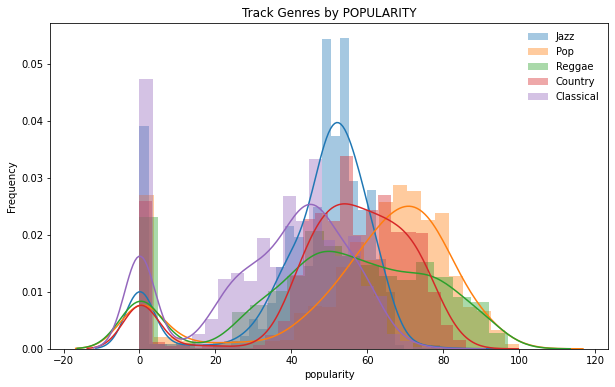

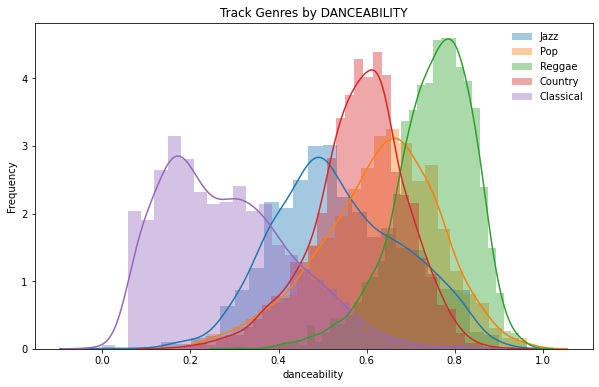

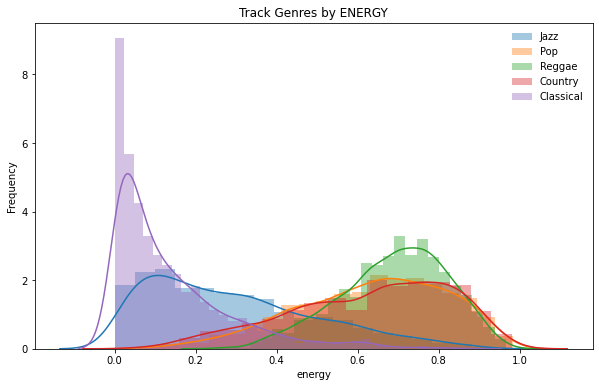

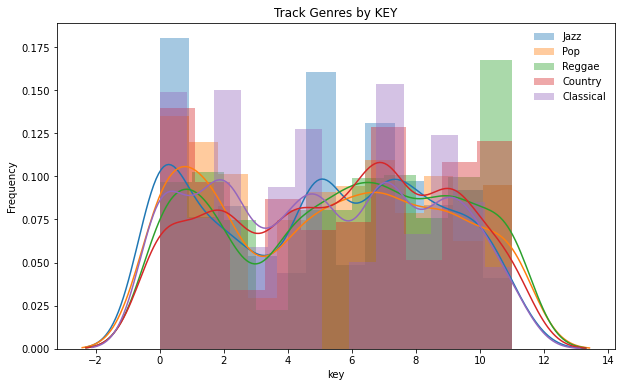

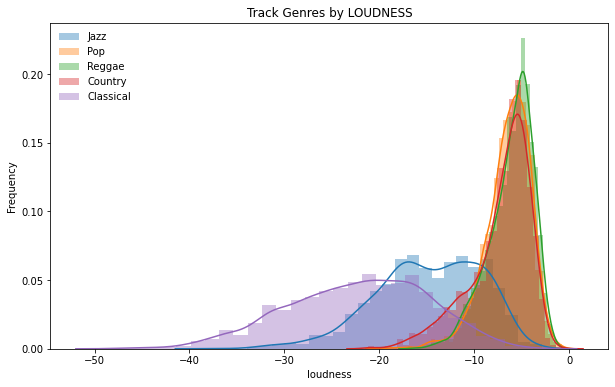

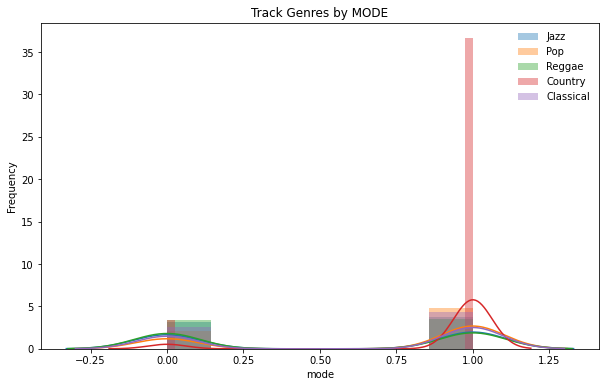

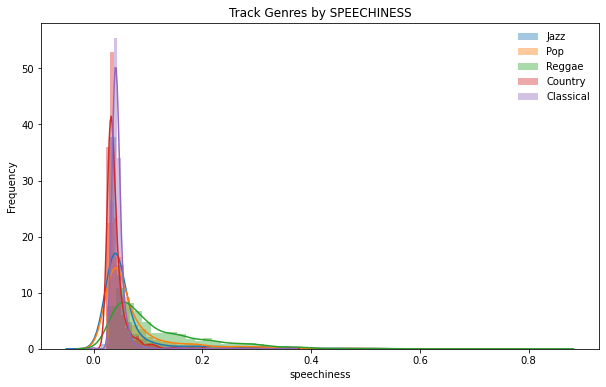

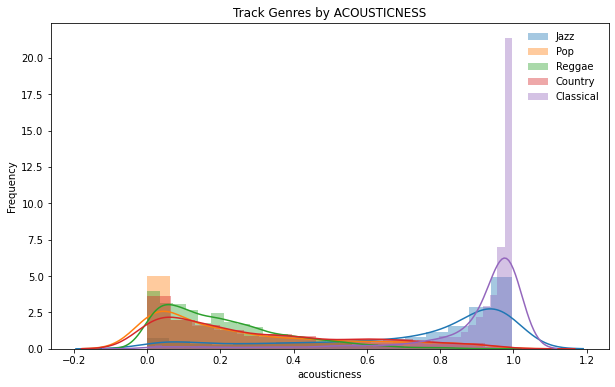

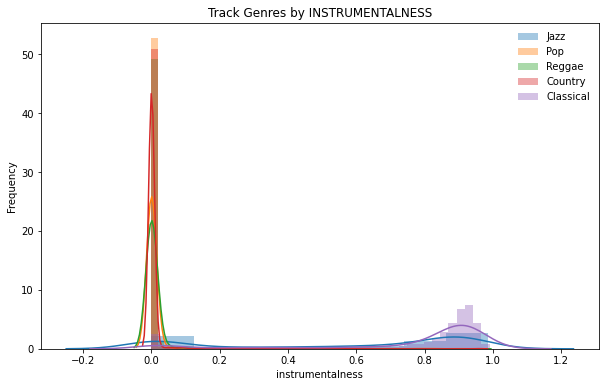

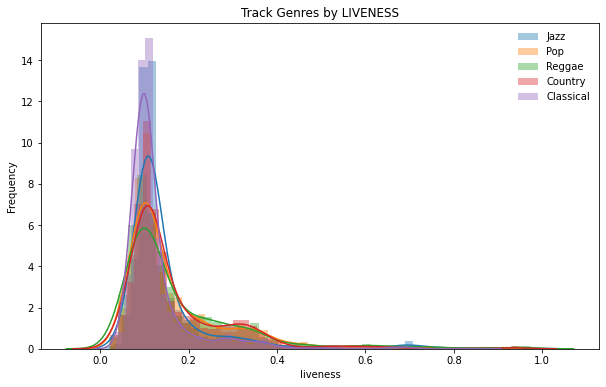

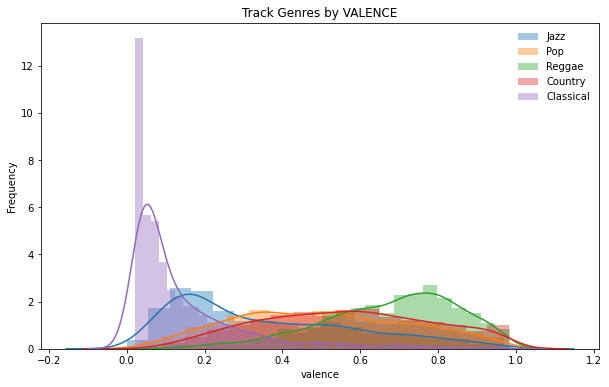

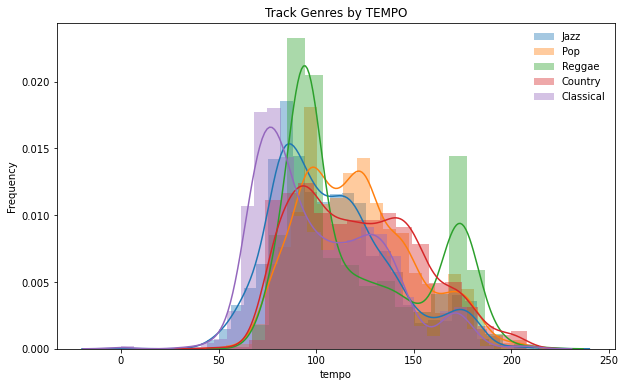

In [3]:
FEATURES = ['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

for col in FEATURES:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    for keyword in KEYWORDS: 
        df = tracks_df[tracks_df.genre == keyword]
        sns.distplot(df[col], ax=ax, label=keyword)
    
    plt.title(f'Track Genres by {col.upper()}')
    plt.ylabel('Frequency')
    plt.legend(frameon=False)
    plt.show()

### 3. Feature Engineering

In [4]:
# retain only distinct tracks per keyword
tracks_df = tracks_df.drop_duplicates(subset='track_id')
print(f'\n\n\ntracks_df shape: {tracks_df.shape}\n\n')

# normalize loudness and tempo
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
tracks_df[['loudness', 'tempo']] = scaler.fit_transform(tracks_df[['loudness', 'tempo']])
print('\n\n\nNormalize `loudness` and `tempo`')
print(tracks_df[['loudness', 'tempo']].describe())

# map genres to numbers
tracks_df['genre_id'] = tracks_df['genre'].map( {k: v+1 for v, k in enumerate(KEYWORDS)} )
print('\n\n\nMap `Genres` to Numbers')
print(tracks_df['genre_id'].value_counts())




tracks_df shape: (8750, 25)





Normalize `loudness` and `tempo`
          loudness        tempo
count  8750.000000  8750.000000
mean      0.748561     0.514030
std       0.176420     0.147790
min       0.000000     0.000000
25%       0.640443     0.400112
50%       0.812318     0.486353
75%       0.887230     0.613202
max       1.000000     1.000000



Map `Genres` to Numbers
5    2387
1    1746
2    1651
3    1631
4    1335
Name: genre_id, dtype: int64


### 4. Tuning the Model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(7000, 9)
Shape of y_Train:(7000,)
Shape of X_Test:(1750, 9)
Shape of y_Test:(1750,)
Finding best k...


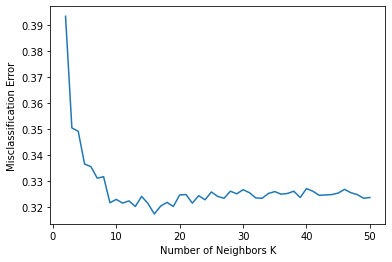

The optimal number of neighbors is 16 with score 68%
Test set accuracy: 68%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(7000, 9)
Shape of y_Train:(7000,)
Shape of X_Test:(1750, 9)
Shape of y_Test:(1750,)
Finding best k...


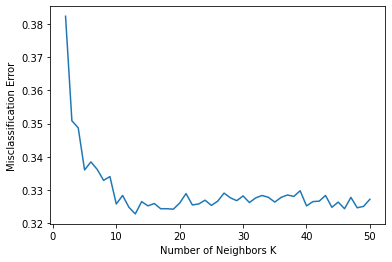

The optimal number of neighbors is 13 with score 67%
Test set accuracy: 68%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(7000, 9)
Shape of y_Train:(7000,)
Shape of X_Test:(1750, 9)
Shape of y_Test:(1750,)
Finding best k...


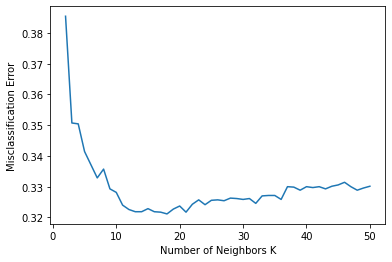

The optimal number of neighbors is 18 with score 67%
Test set accuracy: 70%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(7000, 9)
Shape of y_Train:(7000,)
Shape of X_Test:(1750, 9)
Shape of y_Test:(1750,)
Finding best k...


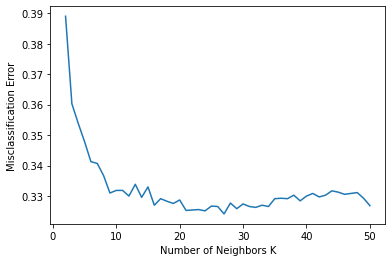

The optimal number of neighbors is 27 with score 67%
Test set accuracy: 70%


In [5]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
results_optimal_k = None

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = d
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=d, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X, y)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))
    
    # predict the response
    pred = knn_optimal.predict(X_test)
    # evaluate accuracy
    acc = accuracy_score(Y_test, pred) * 100
    print("Test set accuracy: %d%%" % (acc))

In [12]:
print(optimal_k)

27


In [8]:
# print(classification_report(y,knn_optimal.predict(X)))
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           1       0.73      0.72      0.72       328
           2       0.55      0.51      0.53       327
           3       0.70      0.79      0.74       336
           4       0.52      0.53      0.53       266
           5       0.90      0.86      0.88       493

    accuracy                           0.71      1750
   macro avg       0.68      0.68      0.68      1750
weighted avg       0.71      0.71      0.70      1750



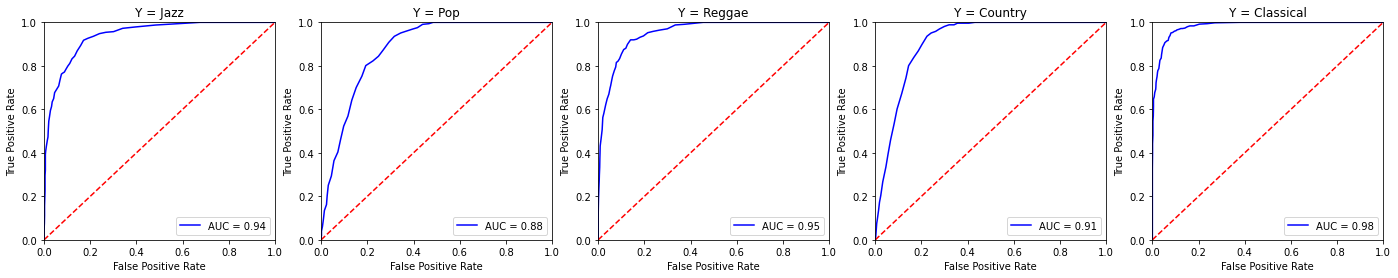

In [9]:
y_scores = knn_optimal.predict_proba(X_test)
genres = tracks_df['genre'].unique()

fig = plt.figure(figsize=[24,4])

for i in np.arange(len(genres)):
    genre_id = i+1
    y_test =[1 if k==genre_id else 0 for k in Y_test]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, i])
    roc_auc = auc(fpr, tpr)

    # ax = fig.add_subplot('1'+str(len(genres))+str(i))
    ax = fig.add_subplot('1'+str(len(genres))+str(genre_id)) # TEAM_RODS
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Y = '+str(genres[i]))
    plt.savefig('AUC.png', dpi=600)